## Testes da rotina da classe das Equações de Mackey-Glass

## 1. Importando as bibliotecas necessárias

### Bibliotecas obrigatórias

In [1]:
import numpy as np
from jitcdde import jitcdde, y, t

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 150

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

plt.style.use('dark_background')

### Bibliotecas não-obrigatórias

In [2]:
import sys 
sys.path.insert(0, '../../../scripts')
import mackeyglassequations as mgeq

## 2. Definindo a função (debug)

Não é necessário executar essa linha se você estiver importando o arquivo com a classe.

In [3]:
class MackeyGlass:
    
    def __init__(self, inicializacao='padrao', tau=6, gamma=0.1, beta=0.2, theta=1, n=10, dt=1.0):
        """
        Descrição:
        ----------
        Construtor da classe 'MackeyGlass'

        Parâmetros:
        -----------
        inicializacao: str
            String referente ao tipo de valores iniciais utilizado para as equações. 
            Se for 'padrao', utiliza a mesma usada no paper de Mackey e Glass, ie, 0.1 para todos os instantes anteriores ao início da medição.
            Caso seja 'aleatoria', utiliza valores aleatorios para esses instantes anteriores.
        tau: int
            Parâmetro das Equações de Mackey-Glass
        gamma: int ou float
            Parâmetro das Equações de Mackey-Glass
        beta: int ou float
            Parâmetro das Equações de Mackey-Glass
        theta: int ou float
            Parâmetro das Equações de Mackey-Glass
        n: int ou float
            Parâmetro das Equações de Mackey-Glass
        dt: float
            Tamanho do diferencial de tempo que iremos utilizar nos cálculos, ou seja, a resolução temporal de nossa solução
            
        Retorna:
        --------
        Nada
        """
        
        if not (type(inicializacao) is str):
            raise TypeError("O tipo da inicialização deve ser uma string!")
        
        if not (((type(gamma) is int) | (type(gamma) is float)) & (gamma > 0)):
            raise TypeError("Gamma deve ser um int ou float positivo!")

        if not (((type(beta) is int) | (type(beta) is float)) & (beta > 0)):
            raise TypeError("Beta deve ser um int ou float positivo!")

        if not (((type(theta) is int) | (type(theta) is float)) & (theta > 0)):
            raise TypeError("Theta deve ser um int ou float positivo!")
                
        if not (((type(tau) is int) | (type(tau) is float)) & (tau > 0)):
            raise TypeError("Tau deve ser um int ou float positivo!")
                
        if not (((type(n) is int) | (type(n) is float)) & (n > 0)):
            raise TypeError("n deve ser um int ou float positivo!")
            
        if not ((type(dt) is float) & (dt > 0)):
            raise TypeError("dt deve ser um float positivo!")
        
        if (inicializacao == 'padrao'):
            p_iniciais = (np.ones((tau, 1))*0.1)*theta
            
        elif (inicializacao == 'aleatoria'):
            p_iniciais = np.random.rand(tau, 1)*theta
            
        else:
            raise ValueError("O tipo da inicialização deve ser um dos dois apresentados(aleatoria ou padrao)!")
        
        self._p_iniciais = p_iniciais
        self._gamma = gamma
        self._beta = beta
        self._theta = theta
        self._tau = tau
        self._n = n
        self._dt = dt
        pass
    
    def _equacao(self):
        """
        Descrição:
        ----------
        Função interna que retorna as equações de Mackey-Glass calculadas no instante t atual
        
        Parâmetros:
        -----------
        Nenhum
        
        Retorna:
        --------
        A equação de Mackey-Glass para os parâmetros estimados na forma de um array
        """     
        
        gamma = self._gamma
        beta = self._beta
        tau = self._tau
        theta = self._theta
        n = self._n
        
        dp_dt = ((beta)*y(0,t-tau)*(theta**n))/((theta**n) + (y(0,t-tau))**n) - gamma*y(0)
        return [dp_dt]
    
    def calcular(self, t_inicial, t_final):
        """
        Descrição:
        ----------
        Evolui as equações de Mackey-Glass com base nas condições iniciais configuradas, para um t indo de t_inicial até t_final,
        
        Parâmetros:
        -----------
        t_inicial: int
            Dia em que iniciamos os cálculos
        t_final: int
            Dia em que terminamos os cálculos
            
        Retorna:
        --------
        Um vetor com as soluções estimadas e um vetor com os instantes temporais utilizados
        """
        
        if not ((type(t_inicial) is int) & (t_inicial >= 0)):
            raise TypeError("t_inicial deve ser um int não nulo!")
            
        if not ((type(t_final) is int) & (t_final > 0)):
            raise TypeError("t_final deve ser um int positivo!")
        
        p_iniciais = self._p_iniciais
        dt = self._dt
        
        p_derivadas_iniciais = np.zeros(len(p_iniciais))
        t_anteriores = np.arange(-len(p_iniciais), 0, 1)
        condicoes_iniciais = []
        
        for i in range(0, len(p_iniciais), 1):
            condicao = (t_anteriores[i], p_iniciais[i], p_derivadas_iniciais[i])
            condicoes_iniciais.append(condicao)
        
        equacao = self._equacao()
        DDE = jitcdde(equacao)
        
        DDE.add_past_points(condicoes_iniciais)
        DDE.step_on_discontinuities()
        DDE.set_integration_parameters(first_step = dt, max_step = dt)
        
        instantes_temporais = np.arange(t_inicial, t_final, dt)
        t_integracao = np.arange(DDE.t + t_inicial, DDE.t + t_final, dt)
        
        solucoes = []
        for t in t_integracao:
            solucoes.append(DDE.integrate(t))
        
        return solucoes, instantes_temporais

## 3. Testando a classe

In [4]:
t_inicial = 0
t_final = 800
tau = 6
n = 10
gamma = 0.1
beta = 0.2
theta = 1

In [5]:
macglass = mgeq.MackeyGlass(tau=tau, gamma=gamma, beta=beta, n=n, theta=theta)

In [6]:
solucoes, instantes_temporais = macglass.calcular(t_inicial = t_inicial, t_final = t_final)

Generating, compiling, and loading C code.
Using default integration parameters.


### 3.a) Série Temporal I de Mackey-Glass

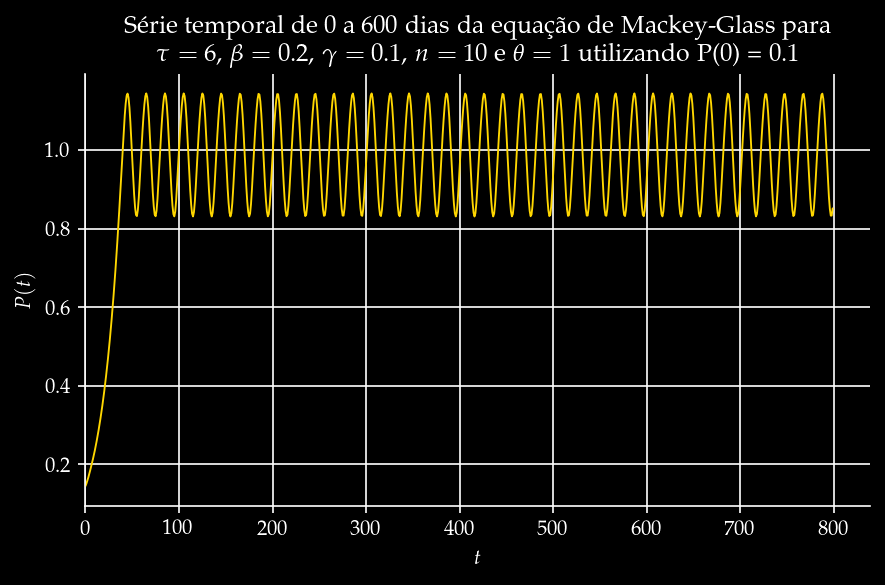

In [7]:
fig, ax = plt.subplots()
ax.set_title('Série temporal de 0 a 600 dias da equação de Mackey-Glass para\n' + r'$\tau =$ ' + str(tau) + r', $\beta =$ ' + str(beta) + r', $\gamma =$ ' + str(gamma) + r', $n =$ ' + str(n) + r' e $\theta =$ ' + str(theta) + ' utilizando P(0) = ' + str(0.1*theta))
ax.plot(instantes_temporais, solucoes, color='Gold', linewidth=0.9)

ax.set_ylabel('$P(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(0,)
    
ax.grid(True)

fig.tight_layout()
sns.despine()
plt.show()
fig.savefig("../../../images/caos/mackeyglass/serie-temporal-1.png")

### 3.b) Atrator I de Mackey-Glass

#### Visualização em 2D

In [8]:
p_atual_2D = np.array([])
p_tau_2D = np.array([])   

In [9]:
for i in range(tau, len(solucoes)):
    p_atual_2D = np.append(p_atual_2D, solucoes[i])
    p_tau_2D = np.append(p_tau_2D, solucoes[i - tau])

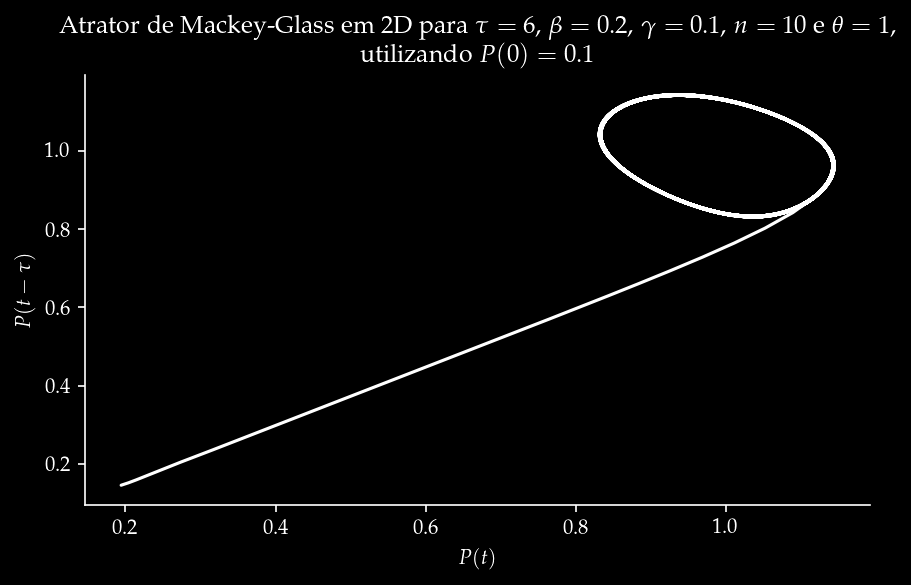

In [10]:
fig, ax = plt.subplots()
ax.set_title('Atrator de Mackey-Glass em 2D para ' + r'$\tau =$ ' + str(tau) + r', $\beta =$ ' + str(beta) + r', $\gamma =$ ' + str(gamma) + r', $n =$ ' + str(n) + r' e $\theta =$ ' + str(theta) + 
             ',\n utilizando $P(0) =$ ' + str(0.1*theta))
ax.plot(p_atual_2D, p_tau_2D, color='White')

ax.set_ylabel(r'$P(t - \tau)$')
ax.set_xlabel('$P(t)$')


ax.grid(False)

fig.tight_layout()
sns.despine()
plt.show()
fig.savefig("../../../images/caos/mackeyglass/atrator-1-2d.png")

#### Visualização em 3D

In [11]:
p_atual_3D = np.array([])
p_tau_3D = np.array([])   
p_2tau_3D = np.array([])

In [12]:
for i in range(2*tau, len(solucoes)):
    p_atual_3D = np.append(p_atual_3D, solucoes[i])
    p_tau_3D = np.append(p_tau_3D, solucoes[i - tau])
    p_2tau_3D = np.append(p_2tau_3D, solucoes[i - 2*tau])

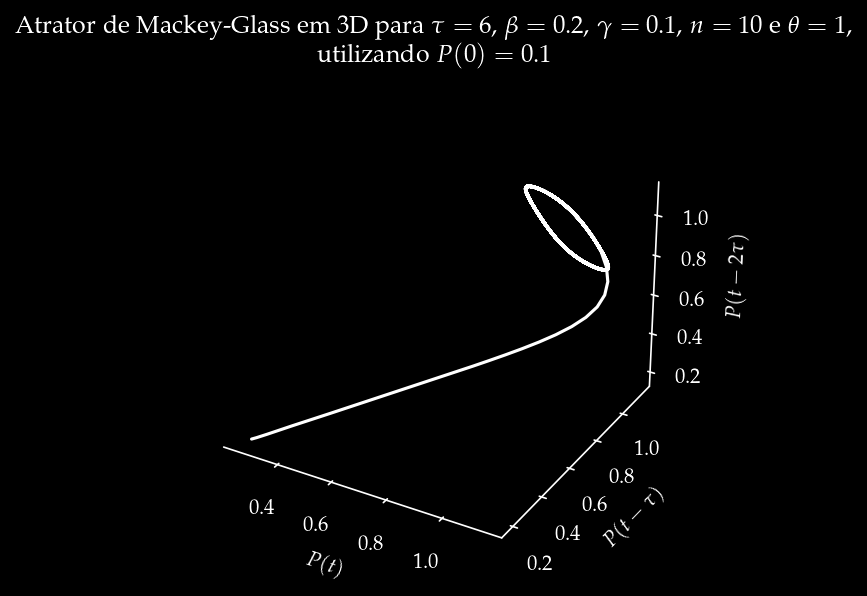

In [13]:
fig, ax = plt.subplots()
ax = plt.axes(projection='3d')

ax.set_title('Atrator de Mackey-Glass em 3D para ' + r'$\tau =$ ' + str(tau) + r', $\beta =$ ' + str(beta) + r', $\gamma =$ ' + str(gamma) + r', $n =$ ' + str(n) + r' e $\theta =$ ' + str(theta) + 
             ',\n utilizando $P(0) =$ ' + str(0.1*theta))
ax.plot(p_atual_3D, p_tau_3D, p_2tau_3D, color='White')

ax.set_xlabel('$P(t)$')
ax.set_ylabel(r'$P(t - \tau)$')
ax.set_zlabel(r'$P(t - 2\tau)$')


ax.w_xaxis.set_pane_color((0, 0, 0, 0))
ax.w_yaxis.set_pane_color((0, 0, 0, 0))
ax.w_zaxis.set_pane_color((0, 0, 0, 0))

ax.grid(False)

fig.tight_layout()
sns.despine()
plt.show()
fig.savefig("../../../images/caos/mackeyglass/atrator-1-3d.png")

## 4. Testando a classe em caos

In [14]:
t_inicial = 0
t_final = 800
tau = 22
n = 10
gamma = 0.1
beta = 0.2
theta = 1

In [15]:
macglass_caos = mgeq.MackeyGlass(tau=tau, gamma=gamma, beta=beta, n=n, theta=theta)

In [16]:
solucoes, instantes_temporais = macglass_caos.calcular(t_inicial = t_inicial, t_final = t_final)

Generating, compiling, and loading C code.
Using default integration parameters.


### 4.a) Série Temporal II de Mackey-Glass

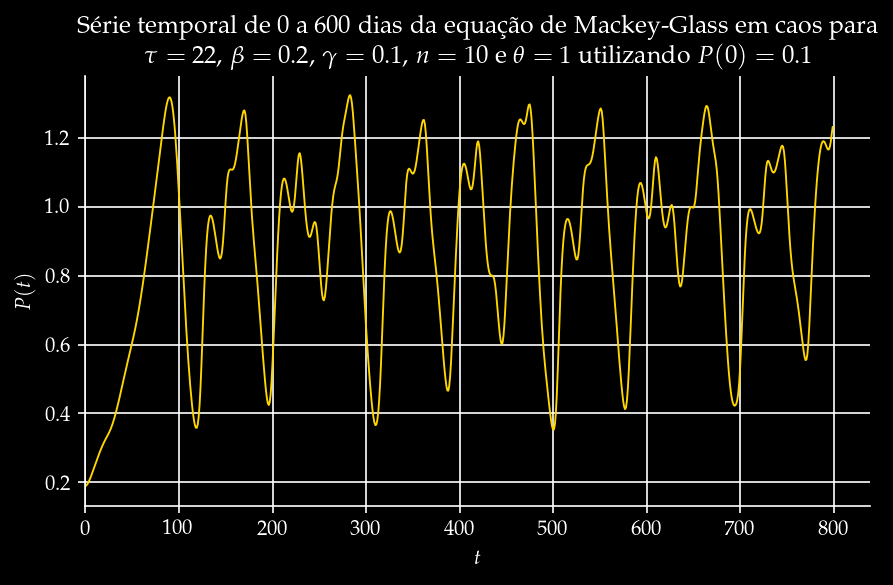

In [17]:
fig, ax = plt.subplots()
ax.set_title('Série temporal de 0 a 600 dias da equação de Mackey-Glass em caos para\n' + r'$\tau =$ ' + str(tau) + r', $\beta =$ ' + str(beta) + r', $\gamma =$ ' + str(gamma) + r', $n =$ ' + str(n) + r' e $\theta =$ ' + str(theta) + ' utilizando $P(0) =$ ' + str(0.1*theta))
ax.plot(instantes_temporais, solucoes, color='Gold', linewidth=0.9)

ax.set_ylabel('$P(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(0,)
    
ax.grid(True)

fig.tight_layout()
sns.despine()
plt.show()
fig.savefig("../../../images/caos/mackeyglass/serie-temporal-2.png")

### 4.b) Atrator II de Mackey-Glass

#### Visualização em 2D

In [18]:
p_atual_2D = np.array([])
p_tau_2D = np.array([])   

In [19]:
for i in range(tau, len(solucoes)):
    p_atual_2D = np.append(p_atual_2D, solucoes[i])
    p_tau_2D = np.append(p_tau_2D, solucoes[i - tau])

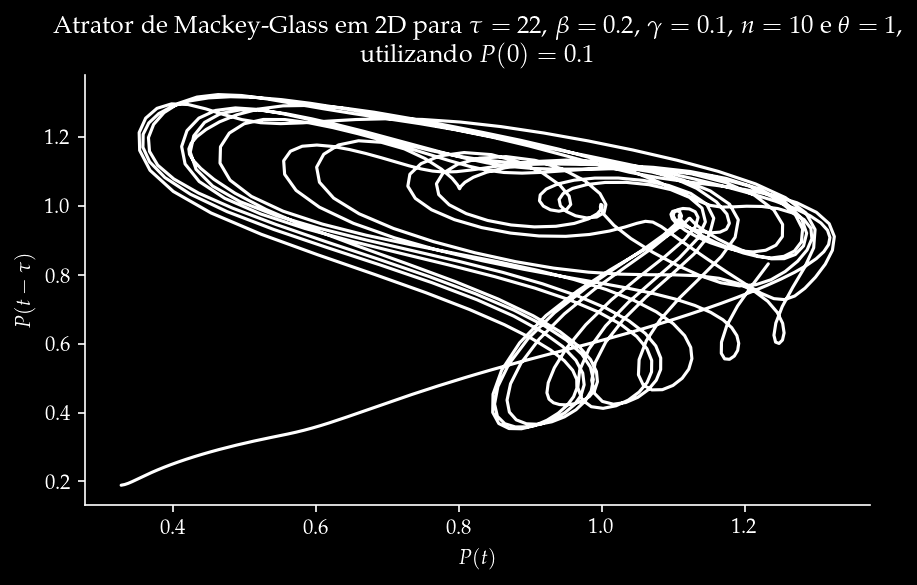

In [20]:
fig, ax = plt.subplots()
ax.set_title('Atrator de Mackey-Glass em 2D para ' + r'$\tau =$ ' + str(tau) + r', $\beta =$ ' + str(beta) + r', $\gamma =$ ' + str(gamma) + r', $n =$ ' + str(n) + r' e $\theta =$ ' + str(theta) + 
             ',\n utilizando $P(0) =$ ' + str(0.1*theta))
ax.plot(p_atual_2D, p_tau_2D, color='White')

ax.set_ylabel(r'$P(t - \tau)$')
ax.set_xlabel('$P(t)$')
ax.grid(False)

fig.tight_layout()
sns.despine()
plt.show()
fig.savefig("../../../images/caos/mackeyglass/atrator-2-2d.png")

#### Visualização em 3D

In [21]:
p_atual_3D = np.array([])
p_tau_3D = np.array([])   
p_2tau_3D = np.array([])

In [22]:
for i in range(2*tau, len(solucoes)):
    p_atual_3D = np.append(p_atual_3D, solucoes[i])
    p_tau_3D = np.append(p_tau_3D, solucoes[i - tau])
    p_2tau_3D = np.append(p_2tau_3D, solucoes[i - 2*tau])

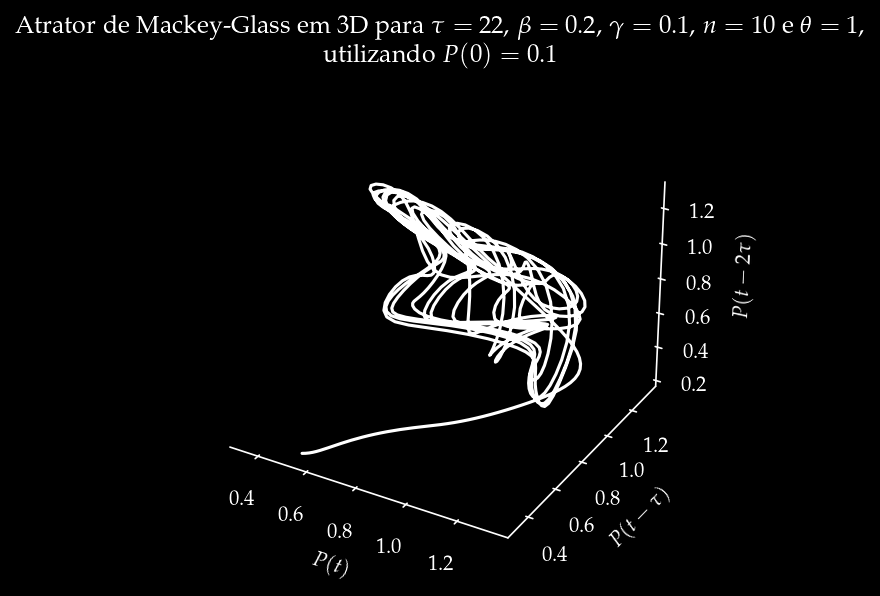

In [23]:
fig, ax = plt.subplots()
ax = plt.axes(projection='3d')

ax.set_title('Atrator de Mackey-Glass em 3D para ' + r'$\tau =$ ' + str(tau) + r', $\beta =$ ' + str(beta) + r', $\gamma =$ ' + str(gamma) + r', $n =$ ' + str(n) + r' e $\theta =$ ' + str(theta) + 
             ',\n utilizando $P(0) =$ ' + str(0.1*theta))
ax.plot(p_atual_3D, p_tau_3D, p_2tau_3D, color='White')

ax.set_xlabel('$P(t)$')
ax.set_ylabel(r'$P(t - \tau)$')
ax.set_zlabel(r'$P(t - 2\tau)$')


ax.w_xaxis.set_pane_color((0, 0, 0, 0))
ax.w_yaxis.set_pane_color((0, 0, 0, 0))
ax.w_zaxis.set_pane_color((0, 0, 0, 0))

ax.grid(False)

fig.tight_layout()
sns.despine()
plt.show()
fig.savefig("../../../images/caos/mackeyglass/atrator-2-3d.png")